In [10]:
%load_ext autoreload
%autoreload 2

In [11]:
import os
import torch
import warnings
from pathlib import Path
from fairseq_transformer_wrapper import FairseqTransformerHub

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import logging
logger = logging.getLogger()
logger.setLevel('WARNING')

In [12]:
europarl_dir = Path(os.environ['EUROPARL_DATA_DIR'])
ckpt_dir = Path(os.environ['EUROPARL_CKPT_DIR'])

#iwslt14_dir = Path(os.environ['IWSLT14_DATA_DIR'])
#ckpt_dir = Path(os.environ['IWSLT14_CKPT_DIR'])

### Alignment test (BPE from Europarl)
test_de_bpe = europarl_dir / "processed_data/test.bpe.de"
test_de_word =  europarl_dir / "processed_data/test.de"
test_en_bpe = europarl_dir / "processed_data/test.bpe.en"
test_en_word = europarl_dir / "processed_data/test.en"
gold_alignment = europarl_dir / "gold_alignment/alignment.talp"

### IWSLT14 test
#test_de_bpe = iwslt14_dir / "test.de"
#test_de_word = iwslt14_dir / "tmp/test.de"
#test_en_bpe = iwslt14_dir / "test.en"
#test_en_word = iwslt14_dir / "tmp/test.en"

warnings.simplefilter('ignore')


with open(test_de_bpe, encoding="utf-8") as fbpe:
    src_bpe_sents = fbpe.readlines()
with open(test_en_bpe, encoding="utf-8") as fbpe:
    tgt_bpe_sents = fbpe.readlines()


model_type = 'baseline'
suffix = '_q_self_attn_head' #'_q_wandb'
seed = 2253                  # 1234

if model_type == 'baseline':
    suffix=''

hub = FairseqTransformerHub.from_pretrained(
    ckpt_dir / f"{model_type}/{seed}",
    checkpoint_file=f"checkpoint_best{suffix}.pt",
    data_name_or_path=(europarl_dir / "processed_data/fairseq_preprocessed_data").as_posix(),
    #(data_name_or_path=iwslt14_dir / "data-bin").as_posix(),
)

In [13]:
for i in range(400):
#i=0
    src_sent, src_tok, src_tensor, tgt_sent, tgt_tok, tgt_tensor = hub.get_sample('test', i)
    print(i)
    print(f"\nSource sentence: \t {src_sent}")
    print(f"Target sentence: \t {tgt_sent}")

0

Source sentence: 	 wir sollten diesen demokratieimpuls unterstützen .
Target sentence: 	 we should support that push for democracy .
1

Source sentence: 	 sie haben sich ihre chance zu wählen verdient .
Target sentence: 	 they have earned their chance to vote .
2

Source sentence: 	 ich fordere das europäische parlament und die europäische kommission auf , unverzüglich mittel für bildung , für die schaffung von grundstrukturen der justiz und der demokratie bereitzustellen .
Target sentence: 	 i call upon the european parliament and the european commission to give funding for education , basic justice and democracy immediately .
3

Source sentence: 	 herr präsident ! nach einem - wie uns in erinnerung gerufen wurde - acht jahre anhaltenden grausamen bürgerkrieg bot das am 7. juli dieses jahres unterzeichnete friedensabkommen die möglichkeit zur beendigung dieses tragischen kapitels und zur friedlichen und dauerhaften beilegung eines konflikts , der unermeßliches leid über die bevölke

In [14]:
i = 7 # 0, 1 28, 45, 148 (pred_tok vs tgt_tok), 178, 16 (Hallucination)

src_sent, src_tok, src_tensor, tgt_sent, tgt_tok, tgt_tensor = hub.get_sample('test', i)
print(f"\nSource sentence: \t {src_sent}")
print(f"Target sentence: \t {tgt_sent}")



Source sentence: 	 da jedoch worte nicht ausreichen , sondern taten erforderlich sind , ersuchen wir nachdrücklich darum , daß maßnahmen ergriffen und mittel bereitgestellt werden , um die erfüllung dieses abkommens zu ermöglichen .
Target sentence: 	 since words are not enough , however , and actions are required , we earnestly request that measures be adopted and means provided that will allow compliance with the agreement .


In [15]:
model_output, log_probs, encoder_out, layer_inputs, layer_outputs = hub.trace_forward(src_tensor, tgt_tensor)

print("\n\nGREEDY DECODING\n")
pred_log_probs, pred_tensor = torch.max(log_probs, dim=-1)
pred_tok = hub.decode(pred_tensor, hub.task.tgt_dict)
pred_sent = hub.decode(pred_tensor, hub.task.tgt_dict, as_string=True)
print(f"Predicted sentence: \t {pred_sent}")

print("\n\nBEAM SEARCH\n")
for pred in hub.generate(src_tensor, 5):
    pred_sent = hub.decode(pred['tokens'], hub.task.tgt_dict, as_string=True)
    score = pred['score'].item()
    print(f"{score} \t {pred_sent}")



GREEDY DECODING

Predicted sentence: 	 since words are not enough , but , but de are needed , we urgeestly request that measures be taken and resources made to will enable this with this agreement to


BEAM SEARCH

-0.6235051155090332 	 however , since words are not enough , deeds are required , we urge that measures be taken and resources allocated to enable this agreement to be implemented .
-0.6253244280815125 	 however , since words are not enough , deeds are needed , we urge that measures be taken and resources be made available to enable this agreement to be implemented .
-0.626814603805542 	 however , since words are not enough , deeds are required , we urge that measures be taken and resources be made available to enable this agreement to be implemented .
-0.6328930258750916 	 however , since words are not enough , deeds are needed , we urge that measures be taken and resources be made available to enable this agreement to be fulfilled .
-0.6385044455528259 	 however , since 

## Local analysis

torch.Size([6, 34, 34])
mean PREF 0.6962474 std 0.06466663


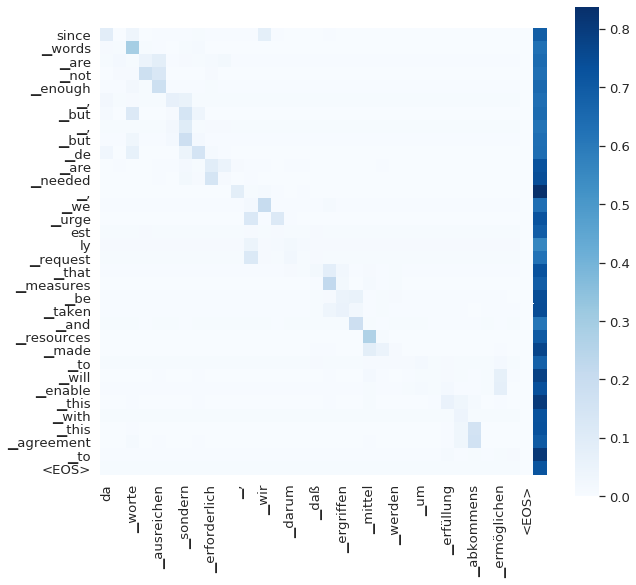

In [16]:
# Cross-attention decoder (local)
corss_attn_contributions = torch.squeeze(hub.get_contributions(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['decoder.encoder_attn'])#encoder.self_attn
print(corss_attn_contributions.size())
layer = 4
corss_attn_contributions = corss_attn_contributions.detach().cpu().numpy()
plt.figure(figsize=(10,10))

#joint_attention_normalized_layer = contributions_mix[joint_attention_layer] / joint_attentions[joint_attention_layer].sum(axis=-1)[...,None]
df = pd.DataFrame(corss_attn_contributions[layer],columns=src_tok + ['<EOS>'] + ['PREF'],index=pred_tok + ['<EOS>'])
sns.set(font_scale=1.2)
sns.heatmap(df,cmap="Blues",square=True)#Reds,,center=0
plt.gcf().subplots_adjust(bottom=0.2)
print('mean PREF',df['PREF'].mean(), 'std', df['PREF'].std())

In [17]:
df.iloc[2]

da                 0.007367
▁jedoch            0.018173
▁worte             0.007387
▁nicht             0.051642
▁ausreichen        0.085824
▁,                 0.006454
▁sondern           0.010187
▁taten             0.006957
▁erforderlich      0.014723
▁sind              0.021073
▁,                 0.005562
▁ersuchen          0.005736
▁wir               0.005567
▁nachdrücklich     0.005636
▁darum             0.005658
▁,                 0.005658
▁daß               0.005558
▁maßnahmen         0.005568
▁ergriffen         0.005577
▁und               0.005533
▁mittel            0.005566
▁bereitgestellt    0.005561
▁werden            0.005560
▁,                 0.005583
▁um                0.005559
▁die               0.005552
▁erfüllung         0.005698
▁dieses            0.005551
▁abkommens         0.005562
▁zu                0.005556
▁ermöglichen       0.005568
▁.                 0.005045
<EOS>              0.000000
PREF               0.647800
Name: ▁are, dtype: float32

torch.Size([6, 34, 34])


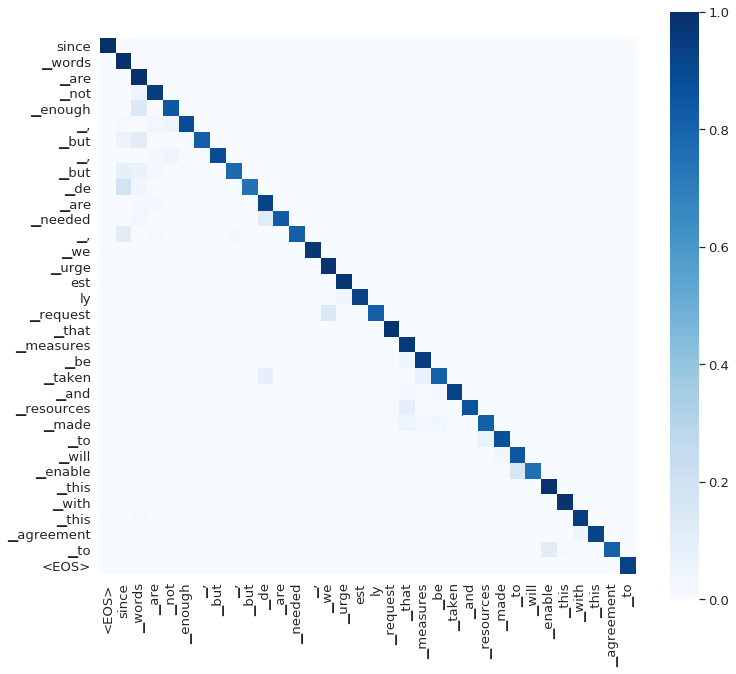

In [18]:
# Self-attention decoder (local)
self_attn_dec_contributions = torch.squeeze(hub.get_contributions(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['decoder.self_attn'])#encoder.self_attn
print(self_attn_dec_contributions.size())
layer = 5
self_attn_dec_contributions = self_attn_dec_contributions.detach().cpu().numpy()
df = pd.DataFrame(self_attn_dec_contributions[layer],columns= ['<EOS>'] + pred_tok, index=pred_tok + ['<EOS>'])
sns.set(font_scale=1.2)
sns.heatmap(df,cmap="Blues",square=True)#Reds,,center=0
plt.gcf().subplots_adjust(bottom=0.2)


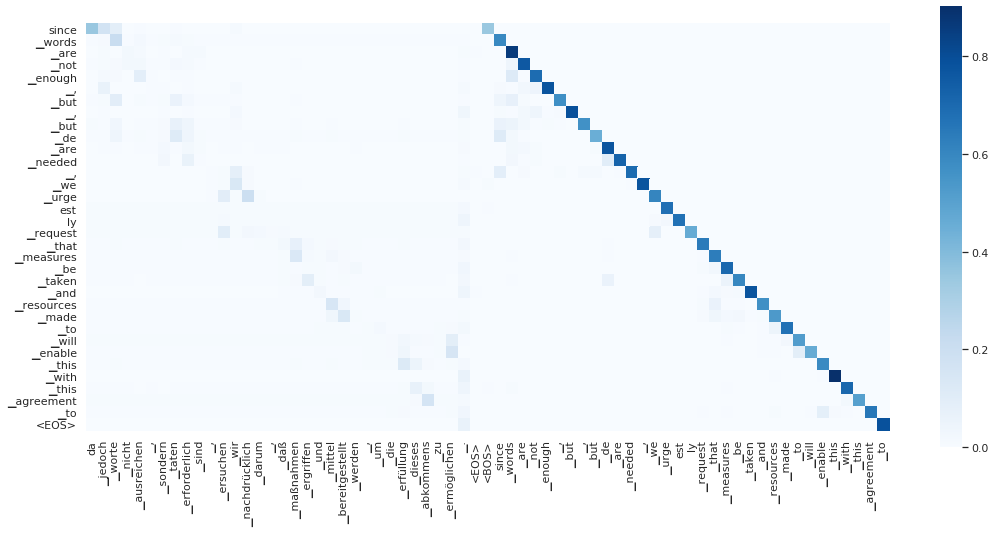

In [19]:
# Cross + self-attention (local)
layer = 0
num_layers = 6
layer = 5
#for layer in range(0,num_layers):
self_dec_contributions = torch.squeeze(hub.get_contributions(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['decoder.self_attn'])#encoder.self_attn
cross_contributions = torch.squeeze(hub.get_contributions(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['decoder.encoder_attn'])#encoder.self_attn
cross_contributions_layer = cross_contributions[layer]

self_dec_contributions_layer = (self_dec_contributions[layer].transpose(0,1)*cross_contributions_layer[:,-1]).transpose(0,1)
cross_contributions_layer = cross_contributions_layer[:,:-1]
final_cross_contributions = torch.cat((cross_contributions_layer,self_dec_contributions_layer),dim=1)
#print(final_cross_contributions)
final_cross_contributions_np = final_cross_contributions.detach().cpu().numpy()

plt.figure(figsize=(18,9))
df = pd.DataFrame(final_cross_contributions_np, columns = src_tok + ['<EOS>'] + ['<BOS>'] + pred_tok, index = pred_tok + ['<EOS>'])
sns.set(font_scale=1)
sns.heatmap(df,cmap="Blues",square=True)#Reds,,center=0
plt.gcf().subplots_adjust(bottom=0.2)



## Global analysis

In [20]:
num_layers = 6

In [21]:
def compute_joint_attention(att_mat):
    """ Compute attention rollout given contributions or attn weights + residual."""

    aug_att_mat =  att_mat
    device = att_mat.device
    joint_attentions = torch.zeros(aug_att_mat.size()).to(device)

    layers = joint_attentions.shape[0]
    joint_attentions[0] = aug_att_mat[0]
    #joint_attentions[0] = joint_attentions[0] / joint_attentions[0].sum(dim=-1,keepdim=True)
    
        
    for i in np.arange(1,layers):
        joint_attentions[i] = torch.matmul(aug_att_mat[i],joint_attentions[i-1])
        
        
    return joint_attentions

# Compute contributions rollout encoder self-attn
enc_self_attn_contributions = torch.squeeze(hub.get_contributions(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['encoder.self_attn'])#encoder.self_attn
enc_self_attn_contributions_mix = compute_joint_attention(enc_self_attn_contributions)
enc_self_attn_contributions_mix.size()
# Get last layer relevances w.r.t input
relevances_enc_self_attn = enc_self_attn_contributions_mix[-1]
# repeat num_layers times
relevances_enc_self_attn = relevances_enc_self_attn.unsqueeze(0).repeat(num_layers, 1, 1)

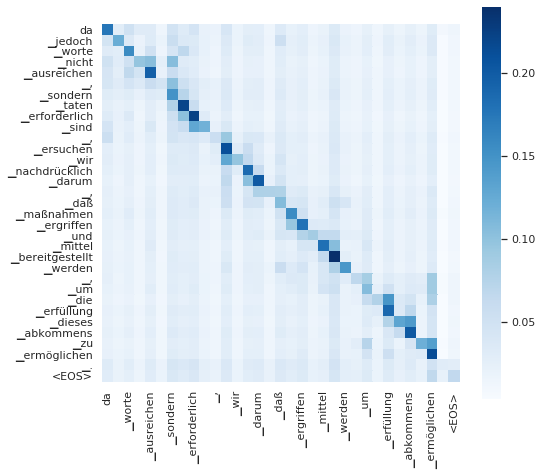

In [22]:
# Encoder self-attention relevances (last layer)
plt.figure(figsize=(8,8))
df = pd.DataFrame(relevances_enc_self_attn[-1].cpu().detach().numpy(),columns=src_tok + ['<EOS>'], index=src_tok + ['<EOS>'])
sns.set(font_scale=1)
sns.heatmap(df,cmap="Blues",square=True)#Reds,,center=0
plt.gcf().subplots_adjust(bottom=0.2)

In [23]:
def compute_joint_attention_nmt(att_mat, src_len):
    """ Contributions rollout whole Transformer-NMT model"""

    aug_att_mat =  att_mat
    device = att_mat.device
    joint_attentions = torch.zeros(aug_att_mat.size()).to(device)

    layers = joint_attentions.shape[0]
    joint_attentions[0] = aug_att_mat[0]
    #s[0] = joint_attentions[0] / joint_attentions[0].sum(dim=-1,keepdim=True)
    
    for l in np.arange(1,layers):
        #print('aug_att_mat[l]', aug_att_mat[l])
        for i in np.arange(0,aug_att_mat.size(1)):
            for j in np.arange(0,aug_att_mat.size(2)):
                # print('aug_att_mat[l,i,src_len:src_len+i+1]',aug_att_mat[l,i,src_len:src_len+i+1])
                # print('joint_attentions[l-1,0:i+1,j])', joint_attentions[l-1,0:i+1,j])
                if j < src_len:
                    # Sum C^l_{i,j} only when measuring contributions of source (j<src_len)
                    joint_attentions[l,i,j] = torch.dot(aug_att_mat[l,i,src_len:src_len+i+1],joint_attentions[l-1,0:i+1,j]) + aug_att_mat[l,i,j]
                else:
                    joint_attentions[l,i,j] = torch.dot(aug_att_mat[l,i,src_len:src_len+i+1],joint_attentions[l-1,0:i+1,j])
                
        joint_attentions[l] = joint_attentions[l] / joint_attentions[l].sum(dim=-1,keepdim=True)
                #print(joint_attentions[l,i,j])
        
        
    return joint_attentions

(6, 34, 67)


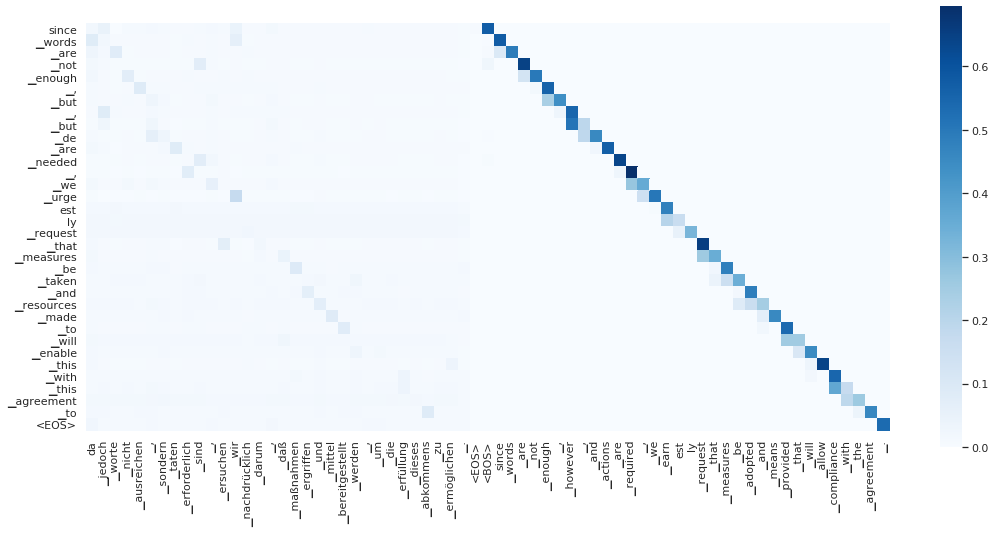

In [24]:
# Compute joint cross + self attention
self_dec_contributions = torch.squeeze(hub.get_contributions(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['decoder.self_attn'])#encoder.self_attn
cross_contributions = torch.squeeze(hub.get_contributions(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['decoder.encoder_attn'])#encoder.self_attn
self_dec_contributions = (self_dec_contributions.transpose(1,2)*cross_contributions[:,:,-1].unsqueeze(1)).transpose(1,2)
#print('self_dec_contributions',self_dec_contributions[layer].sum(-1))
cross_contributions = cross_contributions[:,:,:-1]

#print(relevances_enc_self_attn.size())
# Combine encoder self-attention relevances (rollout) with cross-attention contributions
final_cross_contributions = torch.bmm(cross_contributions, relevances_enc_self_attn)

#joint_self_cross_contributions = torch.cat((final_cross_contributions,self_dec_contributions),dim=-1)
# b) no encoder rollout
joint_self_cross_contributions = torch.cat((cross_contributions,self_dec_contributions),dim=-1)

# Cross (rollout) + self-attention (local)
num_layers = 6
layer = 0

joint_self_cross_contributions_np = joint_self_cross_contributions.detach().cpu().numpy()
print(joint_self_cross_contributions_np.shape)
plt.figure(figsize=(18,9))
df = pd.DataFrame(joint_self_cross_contributions_np[layer], columns = src_tok + ['<EOS>'] + ['<BOS>'] + tgt_tok, index = pred_tok + ['<EOS>'])
sns.set(font_scale=1)
sns.heatmap(df,cmap="Blues",square=True)#Reds,,center=0
plt.gcf().subplots_adjust(bottom=0.2)

In [25]:
src_len = len(src_tok + ['<EOS>'])
contributions_rollout = compute_joint_attention_nmt(joint_self_cross_contributions, src_len)



Target sentence: 	 since words are not enough , however , and actions are required , we earnestly request that measures be adopted and means provided that will allow compliance with the agreement .


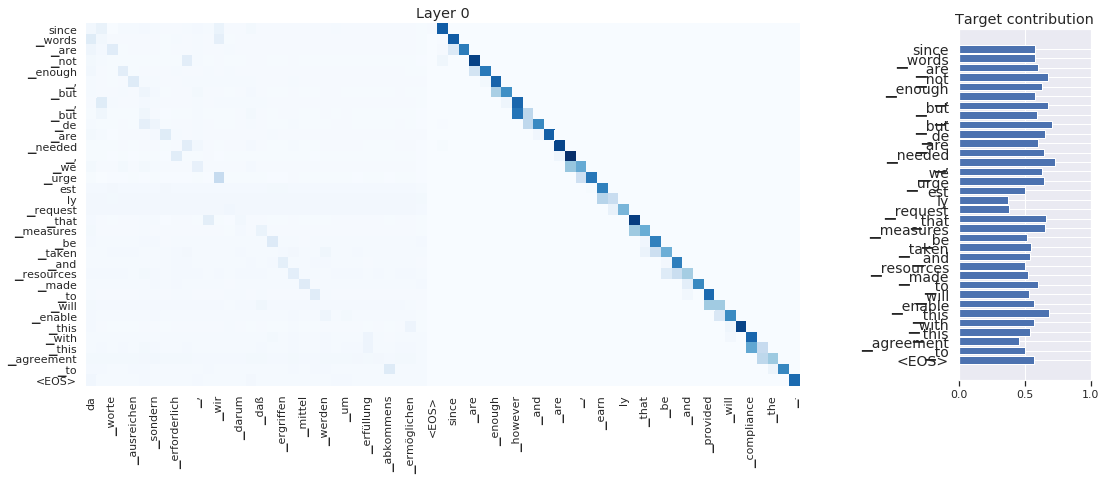

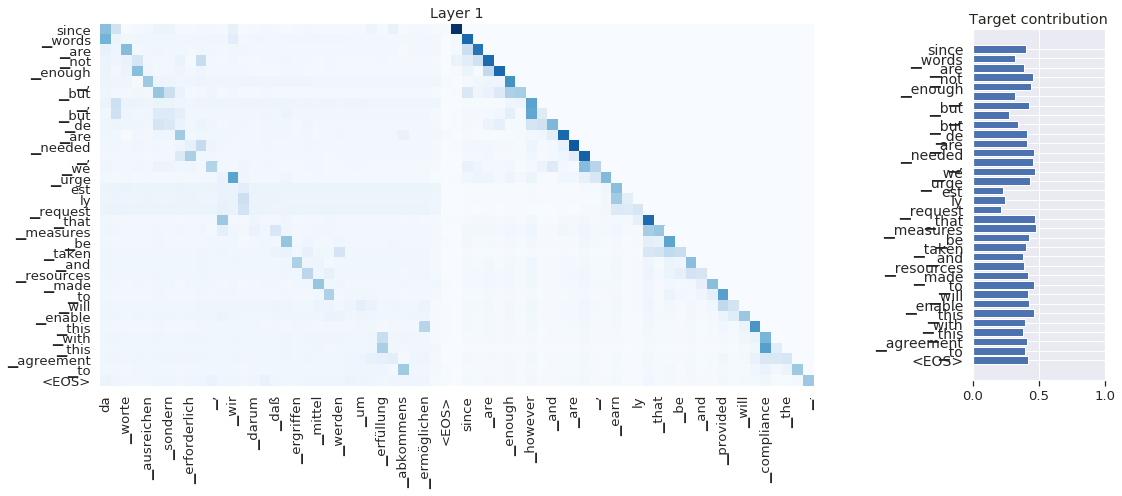

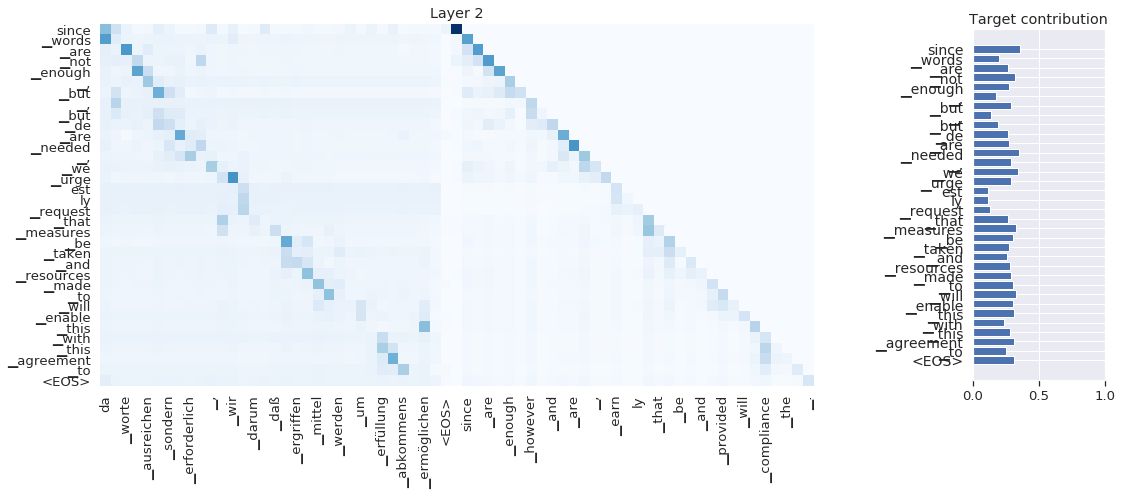

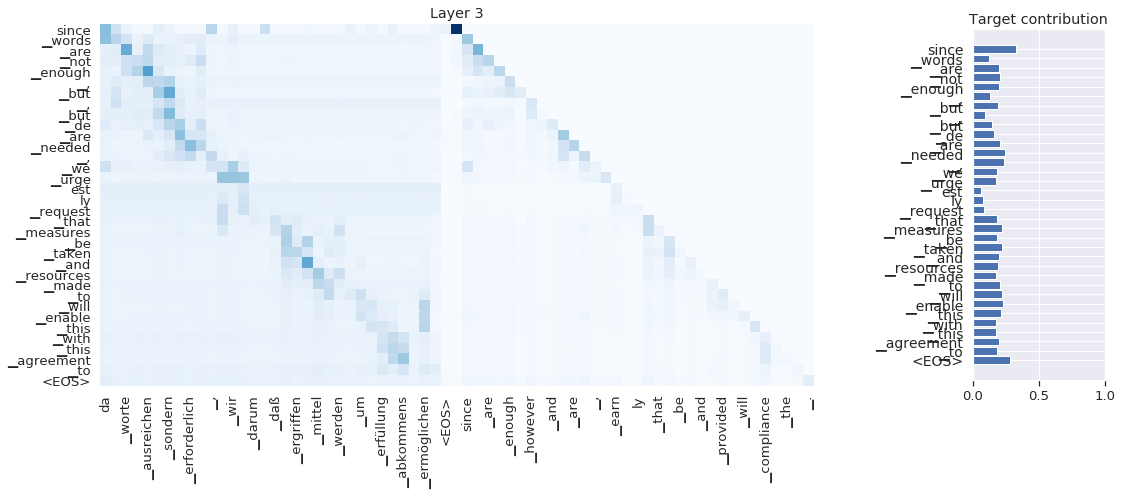

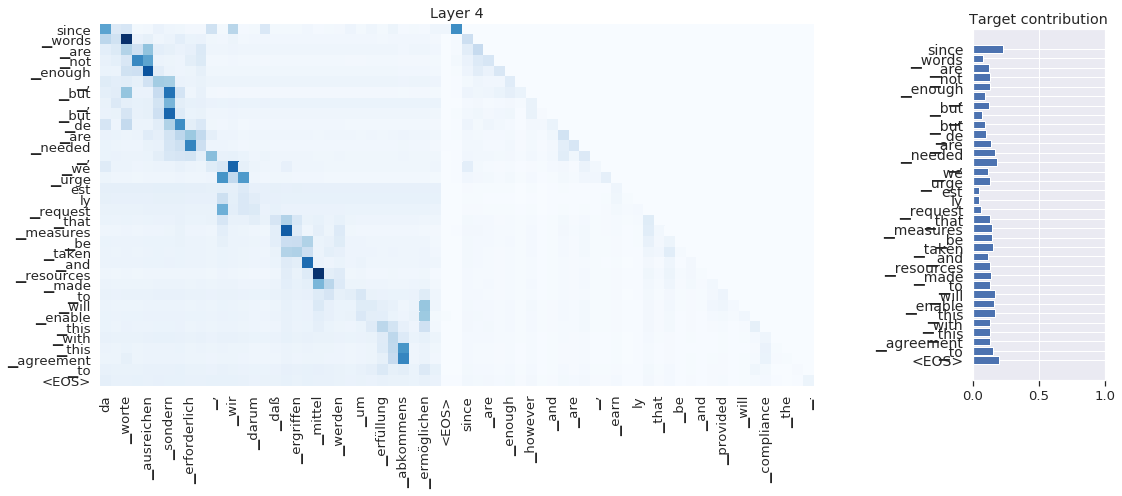

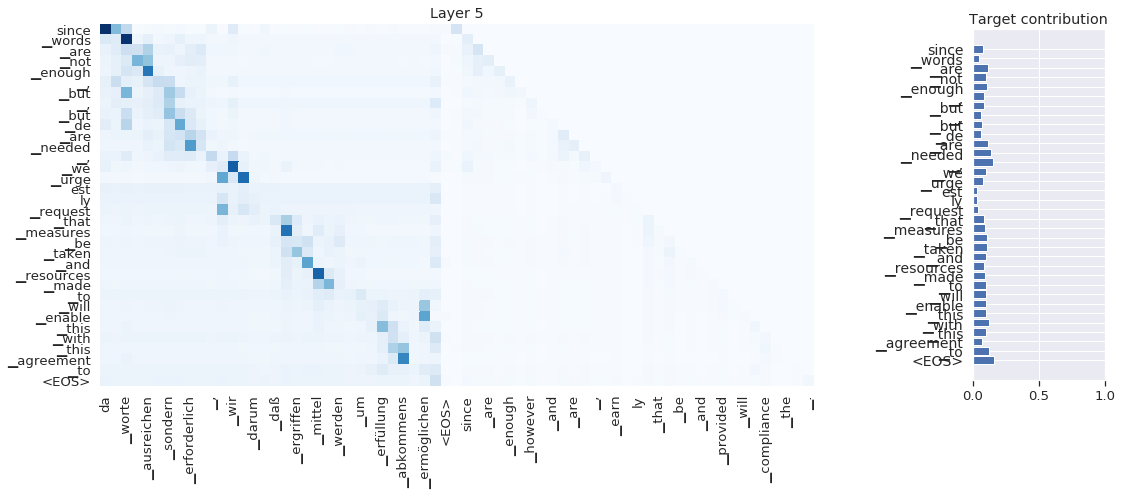

In [26]:
from matplotlib.gridspec import GridSpec

# Cross + self-attention
layer = 0

print(f"Target sentence: \t {tgt_sent}")
for layer in range(0,num_layers):
    #fig, axs = plt.subplots(1, 2,figsize=(20,12),sharey=False,gridspec_kw={'width_ratios': [4, 1]})
    fig = plt.figure(figsize=(18, 20))
    gs = GridSpec(3, 4)
    gs.update(wspace=1.2, hspace=0.05)#0.015
    ax_main = plt.subplot(gs[0:3, :3])
    ax_yDist = plt.subplot(gs[1, 3])#, sharey=ax_main)
    
    contributions_rollout_layer = contributions_rollout[layer]
    contributions_rollout_layer_np = contributions_rollout_layer.detach().cpu().numpy()
    #plt.figure(figsize=(18,9))
    df = pd.DataFrame(contributions_rollout_layer_np, columns = src_tok + ['<EOS>'] + ['<BOS>'] + tgt_tok, index = pred_tok + ['<EOS>'])
    sns.set(font_scale=1.2)
    sns.heatmap(df,cmap="Blues",square=True,ax=ax_main,cbar=False)#Reds,center=0
    tgt_contribution = 1-contributions_rollout_layer_np[:,:len(src_tok)].sum(-1)
    tgt_contribution
    df_tgt_contribution = pd.DataFrame(tgt_contribution, columns = ['tgt_contribution'], index = tgt_tok + ['<EOS>'])
    #sns.set_style("white")
    ax_yDist.barh(range(0,len(tgt_tok + ['<EOS>'])), df_tgt_contribution.tgt_contribution, align='center')
    plt.yticks(ticks = range(0,len(tgt_tok + ['<EOS>'])) ,labels = pred_tok + ['<EOS>'],fontsize='14')
    plt.gca().invert_yaxis()
    plt.grid(visible=True)
    ax_yDist.set_xlim(0,1)

    # sns.barplot(x=df_tgt_contribution.tgt_contribution, y=range(0,len(tgt_tok + ['<EOS>'])), label="Target contribution", color="#1764AB",ax=ax_yDist)
    # ax_yDist.set_yticks(range(0,len(tgt_tok + ['<EOS>'])))
    # ax_yDist.set(xlim=(0, 1),xlabel=None, yticklabels = pred_tok + ['<EOS>'])#yticklabels=[]
    ax_main.set_title('Layer ' + str(layer))
    ax_yDist.set_title('Target contribution')
    #sns.despine(left=True, bottom=True)
    ax_yDist.xaxis.set_ticks_position("bottom")
    # ax_yDist.xaxis.grid(False)
    # ax_yDist.yaxis.grid(False)
    #plt.gcf().subplots_adjust(bottom=0.2)

In [27]:
hub.viz_contributions(src_tensor, tgt_tensor, 'l1', roll=True, norm_mode='min_sum')

c[dec_ed].size() torch.Size([1, 6, 34, 34])


RuntimeError: einsum(): operands do not broadcast with remapped shapes [original->remapped]: [1, 34, 34, 1]->[1, 34, 34, 1, 1] [1, 34, 34]->[1, 1, 34, 1, 34] [1, 33, 33]->[1, 1, 1, 33, 33]

In [ ]:
for s in hub.task.dataset('test'):
    src_sent = hub.decode(s['source'], hub.task.src_dict, as_string=True)
    if 'herr kommissar' in src_sent:
        print(s['id'])
        print(src_sent)
        print('\n')

370
vielen dank , herr kommissar .


402
erfreulicherweise ist der herr kommissar verheugen heute hier anwesend . hoffentlich kann er seinen einfluß geltend machen , um die beitrittskandidaten und andere länder , die mit uns zusammenarbeiten wollen , auf unsere seite zu ziehen und somit eine beachtliche zahl an ratifizierungen zu erhalten .


454
ich danke ihnen für diese erklärung , herr kommissar .


510
herr präsident , herr kommissar , liebe kolleginnen und kollegen , ich schließe mich selbstverständlich dem gemeinsamen entschließungsantrag meiner kolleginnen und kollegen an , und ich möchte sie nochmals auf die überschwemmungen aufmerksam machen , von denen meine region , der äußerste süden frankreichs , heimgesucht wurde .


559
herr kommissar verheugen hat auch sehr deutlich gesagt , daß das parlament sich zu diesem thema äußern soll .




# OLD ⬇️

In [14]:
transformed_vectors = torch.randn((1,23,23,512))
resultant = torch.randn((1,23,512))
resultant_unsqueeze = resultant.unsqueeze(2)
print('resultant_unsqueeze',resultant_unsqueeze.size())
importance_matrix = -F.pairwise_distance(transformed_vectors, resultant_unsqueeze,p=1)

# resultant_repeated = resultant.unsqueeze(2).repeat(1, 1, transformed_vectors.size(1), 1)
# importance_matrix = -torch.cdist(transformed_vectors, resultant_repeated,p=1)
# importance_matrix = torch.einsum('bijj -> bij', importance_matrix)
print('importance_matrix',importance_matrix.size())


resultant_unsqueeze torch.Size([1, 23, 1, 512])
importance_matrix torch.Size([1, 23, 23])


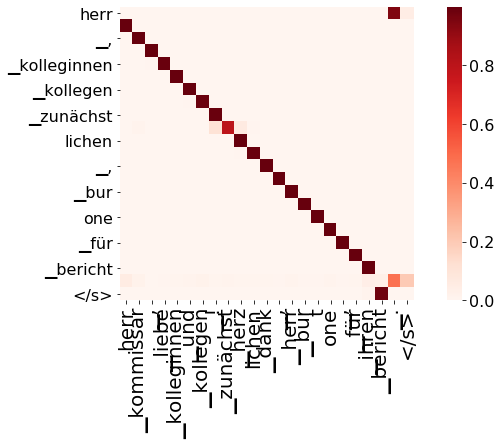

In [15]:
df = pd.DataFrame(attn_weights_heads_list[1][2].cpu().detach().numpy(),columns=source_tokens,index=source_tokens)
sns.heatmap(df,cmap="Reds",square=True)
plt.gcf().subplots_adjust(bottom=0.2)

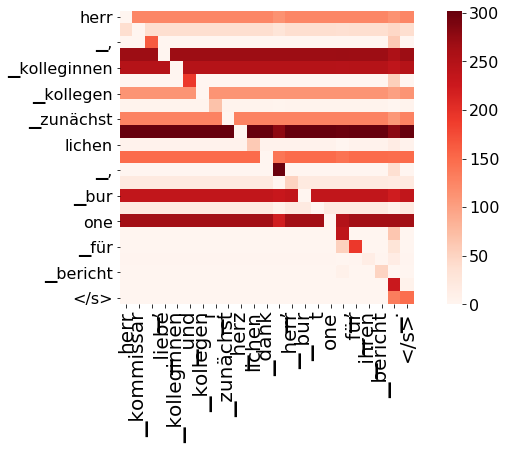

In [16]:
df = pd.DataFrame(normalized_contributions[0].cpu().detach().numpy(),columns=source_tokens,index=source_tokens)
sns.heatmap(df,cmap="Reds",square=True)
plt.gcf().subplots_adjust(bottom=0.2)

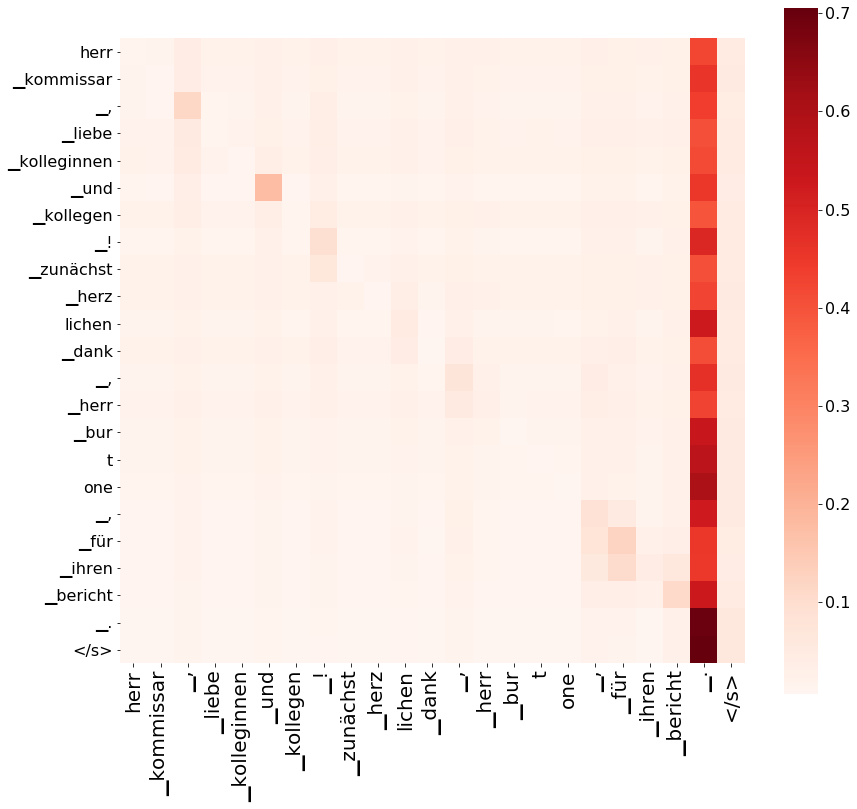

In [17]:
import networkx as nx
joint_attentions = compute_joint_attention(normalized_contributions,add_residual=False)
#joint_attentions = compute_attention_rollout(model_norms)
joint_attentions = joint_attentions.cpu().detach().numpy()
# joint_att_adjmat, joint_labels_to_index = get_adjmat(mat=joint_attentions, input_tokens=source_tokens)
joint_attention_layer = -1

#joint_attention_normalized_layer = joint_attentions[joint_attention_layer] / joint_attentions[joint_attention_layer].sum(axis=-1)[...,None]

fig, ax = plt.subplots(figsize =(14, 14))
df = pd.DataFrame(joint_attentions[joint_attention_layer],columns=source_tokens,index=source_tokens)
sns.heatmap(df,cmap="Reds",square=True,ax=ax)
plt.gcf().subplots_adjust(bottom=0.2)

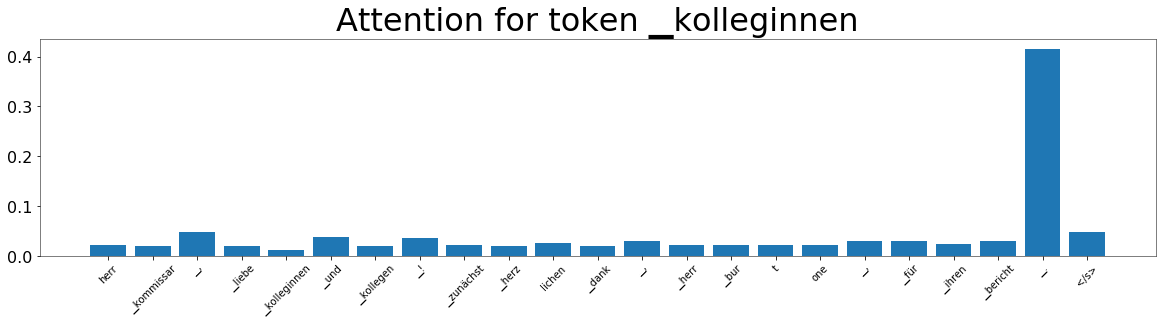

In [18]:
position = 4
# Creating plot
fig = plt.figure(figsize =(20, 4)) 
ax = fig.add_subplot(111) 
ax.bar(np.arange(0,len(source_tokens)),joint_attentions[layer][position])
ax.set_xticks(range(0,len(source_tokens)))
#ax.boxplot(attn_output_vectors);
ax.set_title('Attention for token ' + str(source_tokens[position]))
ax.set_xticklabels(source_tokens, rotation=45, fontsize=10);

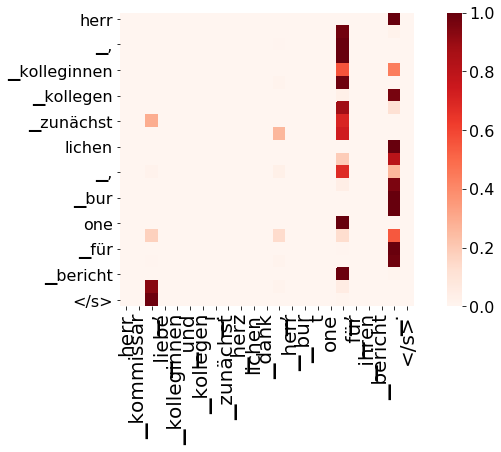

In [19]:

df = pd.DataFrame(attn_weights_heads_list[0][3].cpu().detach().numpy(),columns=source_tokens,index=source_tokens)
sns.heatmap(df,cmap="Reds",square=True)
plt.gcf().subplots_adjust(bottom=0.2)

## Similarity with same token at different layers

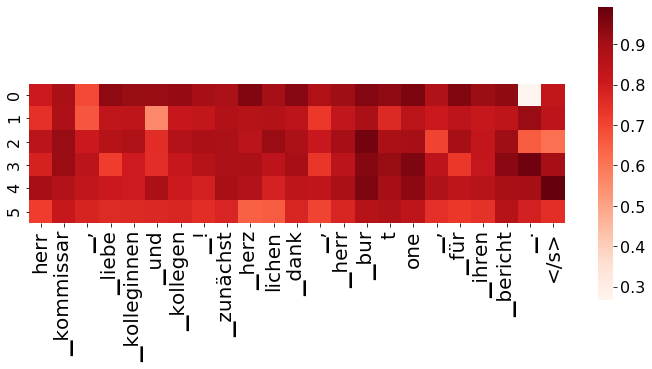

In [21]:
pos = 0
hidden_state_position = []

#fig, ax = plt.subplots(figsize =(14, 14))


for layer in range(num_layers+1):
    hidden_states = torch.squeeze(encoder_out['encoder_states'][layer])
    hidden_state_position.append(hidden_states)

hidden_state_position_stack = torch.stack(hidden_state_position)
similarities_numpy = np.zeros((num_layers, hidden_state_position_stack.size(1)))

cos = nn.CosineSimilarity(dim=0, eps=1e-6)

for layer in range(1,num_layers+1):
    for pos in range(len(source_tokens)):
        output = cos(hidden_state_position_stack[layer][pos], hidden_state_position_stack[layer-1][pos])
        similarities_numpy[layer-1,pos] = output

df = pd.DataFrame(similarities_numpy,columns=source_tokens,index=range(0,num_layers))
sns.heatmap(df,cmap="Reds",square=True)
#ax.set_xticklabels(source_tokens, rotation=45, fontsize=6);
plt.gcf().subplots_adjust(bottom=0.2)


## Similarity with final punctuation mark token

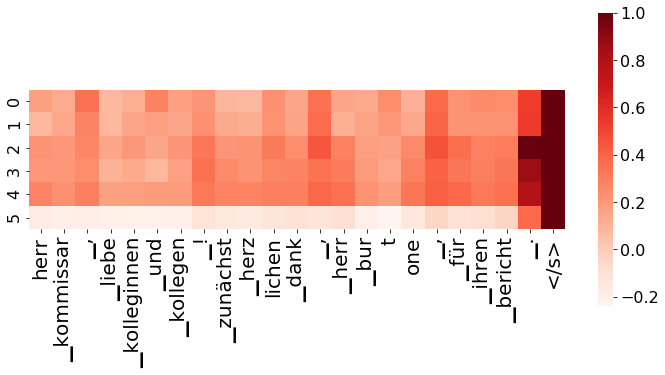

In [22]:
pos = 0
hidden_state_position = []

#fig, ax = plt.subplots(figsize =(14, 14))


for layer in range(num_layers+1):
    hidden_states = torch.squeeze(encoder_out['encoder_states'][layer])
    hidden_state_position.append(hidden_states)

hidden_state_position_stack = torch.stack(hidden_state_position)
similarities_numpy = np.zeros((num_layers, hidden_state_position_stack.size(1)))

cos = nn.CosineSimilarity(dim=0, eps=1e-6)

for layer in range(1,num_layers+1):
    for pos in range(len(source_tokens)):
        output = cos(hidden_state_position_stack[layer][pos], hidden_state_position_stack[layer][-1])
        similarities_numpy[layer-1,pos] = output

df = pd.DataFrame(similarities_numpy,columns=source_tokens,index=range(0,num_layers))
sns.heatmap(df,cmap="Reds",square=True)
#ax.set_xticklabels(source_tokens, rotation=45, fontsize=6);
plt.gcf().subplots_adjust(bottom=0.2)


In [23]:
dense = model.models[0].encoder.layers[3].self_attn.out_proj.weight

print(dense[:,0:64].norm())
print(dense[:,64:129].norm())
print(dense[:,128:191].norm())
print(dense[:,192:].norm())

tensor(8.6928, device='cuda:0', grad_fn=<CopyBackwards>)
tensor(8.8801, device='cuda:0', grad_fn=<CopyBackwards>)
tensor(9.3188, device='cuda:0', grad_fn=<CopyBackwards>)
tensor(18.3294, device='cuda:0', grad_fn=<CopyBackwards>)


In [24]:
layer = 3

v = model.models[0].encoder.layers[layer].self_attn.v_proj(in_self_attn_stack)
#v = v.contiguous().view(bsz, num_heads, -1, 1, head_dim).transpose(1, 2)
v = (
                v.contiguous()
                .view(-1, bsz * num_heads, head_dim)
                .transpose(0, 1)
            )

attn_weights_float = torch.squeeze(encoder_out['attn_weights'][0][layer])
attn_weights_heads_list.append(attn_weights_float)
attn = attn_weights_float.mean(dim=0)
attn_weights_list.append(attn)


# Dense weights W^O: (embed_dim, embed_dim)
dense = model.models[0].encoder.layers[layer].self_attn.out_proj.weight

# Reshape W^O into (num_heads, head_dim, embed_dim)
dense = dense.view(embed_dim, num_heads, head_dim).permute(1,2,0).contiguous()
#dense = dense.view(embed_dim, num_heads, head_dim).permute(1,0,2).contiguous()
# transformed_vectors = v.matmul(dense).view(bsz, -1, num_heads, embed_dim)
# transformed_vectors = transformed_vectors.permute(0, 2, 1, 3)

attn_probs = attn_weights_float.view(bsz*num_heads, src_len, src_len)


In [25]:
import copy

## Delete finalizing tokens and commas
deleted_values = [-1,-2]
source_tokens_trunc = copy.deepcopy(source_tokens)
tokens_to_remove = ['▁,','▁!']#▁,
for i, character in enumerate(source_tokens):
    if character in tokens_to_remove:
        deleted_values.append(i)

for token_to_remove in tokens_to_remove:
    while True:
        try:
            source_tokens_trunc = source_tokens_trunc[:source_tokens_trunc.index(token_to_remove)]+source_tokens_trunc[source_tokens_trunc.index(token_to_remove)+1:]
        except:
            break
source_tokens_trunc = source_tokens_trunc[:-2]


joint_attention_normalized_layer_trunc = np.delete(joint_attention_normalized_layer, deleted_values, 1)

joint_attention_normalized_layer_trunc = joint_attention_normalized_layer_trunc / joint_attention_normalized_layer_trunc.sum(axis=-1)[...,None]


fig, ax = plt.subplots(figsize =(14, 14))
df = pd.DataFrame(joint_attention_normalized_layer_trunc,columns=source_tokens_trunc,index=source_tokens)
sns.heatmap(df,cmap="Reds",square=True,ax=ax)
plt.gcf().subplots_adjust(bottom=0.2)

NameError: name 'joint_attention_normalized_layer' is not defined

## Check norms of values

In [ ]:
layer = 3
v = func_outputs['models.0.encoder.layers.' + str(layer) + '.self_attn.v_proj'][0]
v_joint=torch.squeeze(v)

v = get_cross_attention_projections_by_head(v,n_heads,embed_dim)
print(v.size())
transformed_vectors_box = v.norm(dim=2).data
transformed_vectors_box = transformed_vectors_box.permute(1,0).cpu()
print(transformed_vectors_box.size())
# Creating plot 
fig = plt.figure(figsize =(20, 5)) 
ax = fig.add_subplot(111)

ax.boxplot(transformed_vectors_box)
ax.set_title('Norm value vectors')
ax.set_xticks(range(1,len(source_tokens)+1))
ax.set_xticklabels(source_tokens, rotation=90, fontsize=16);
#ax.set_ylim([0,40])
#legend  = ax.legend(fontsize=14);